In [54]:
pip install astropy sep #This is so I can work on Final on my Ipad also (installing in notebook vs comp)


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [55]:
import numpy as np
import sep


*importing all setup modules and setting figure size!* 

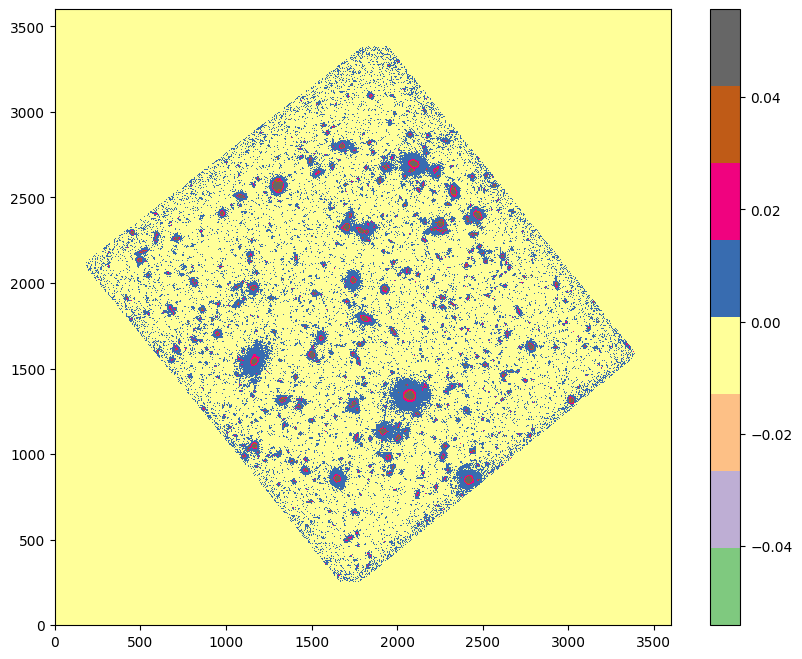

In [56]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]
# "/Users/anthonymartinez/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
with fits.open("/Users/anthonymartinez/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits") as hdul:
    data = hdul[0].data # Open the fits image as a 2D array

#Show the image!
m,s = np.mean(data), np.std(data)
plt.imshow(data,interpolation = 'nearest', cmap = 'Accent', vmin = m - s, vmax= m+s, origin = 'lower') #Accent is a cooler color that also emphazises all zones of activity in the .fits file
plt.colorbar()
plt.savefig('HubbleUltraDeepField.png')

*Background Subtraction- Measuring background, calulating global mean and noise of image, then subtracting the background*

0.0 0.0005398219218477607


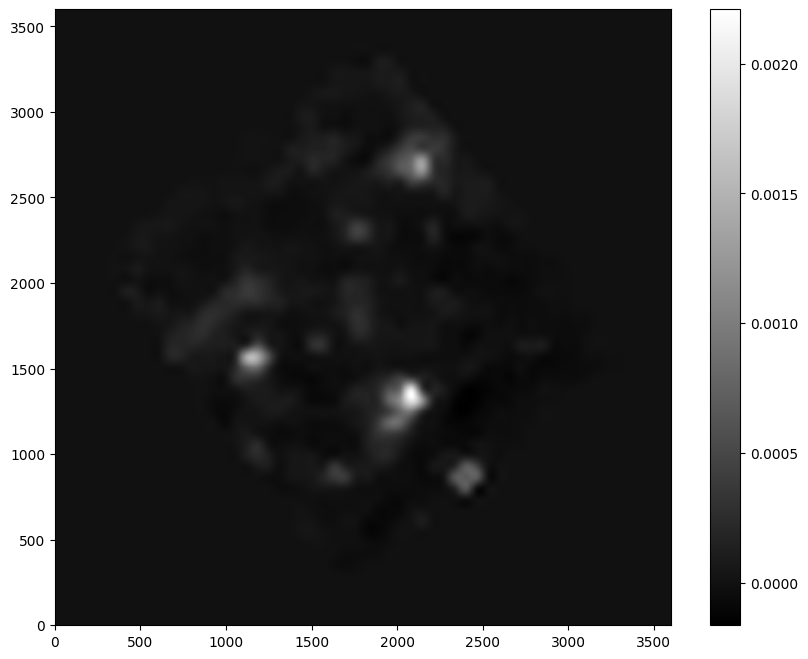

In [57]:
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)

print(bkg.globalback, bkg.globalrms) # get a global mean and noise of the image background.
bkg_image = bkg.back()

plt.imshow(bkg_image, interpolation = 'nearest', cmap = 'gray', origin='lower')
plt.colorbar(); #showing background
bkg_rms = bkg.rms()
plt.savefig('Background.png')

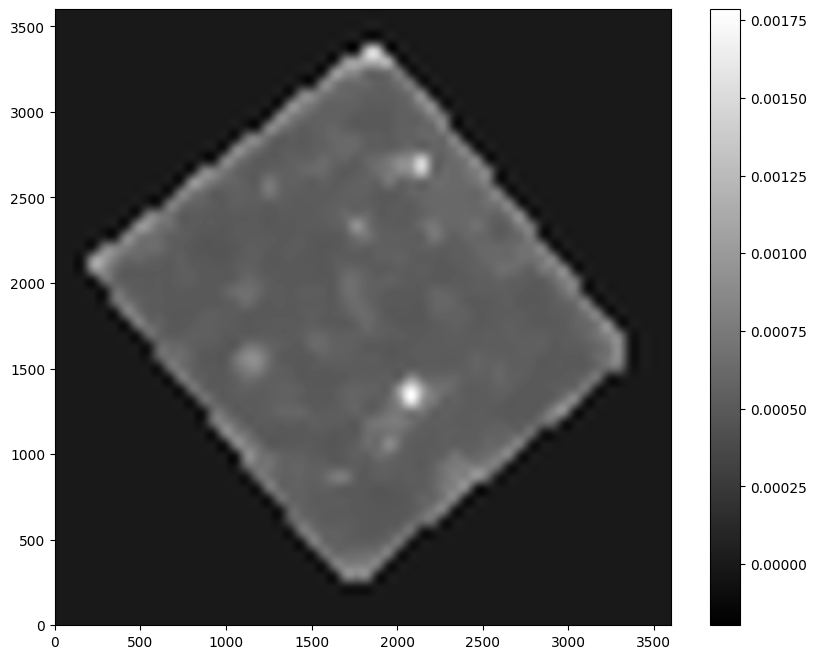

In [58]:
plt.imshow(bkg_rms, interpolation = 'nearest', cmap = 'gray', origin='lower')
plt.colorbar(); # And its noise as well

data_sub = data - bkg #subtract the background
plt.savefig('BackgroundSubtractedHUD.png')

# *Object Deletion:* Running object detection on background-subtracted data! 

In [59]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms) #setting detection threshold = 1.5
#how many objects counted
len(objects) # 8640 Sources found in the UDF image!

8640

# 7. Calculating the mean, median, and the standard deviatian of the distribution of fluxes! *Also finding largest outlier and its deviatation from the mean*

In [66]:
mean_flux =np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux) #standard deviatation

print('Mean of the distribution of fluxes is: {}'.format(mean_flux))
print('Median of the distribution of fluxes is: {}'.format(median_flux))
print('Standard Deviation of the distribution of fluxes is: {}'.format(std_flux))

#identifying outlier and its deviation from mean
deviations = np.abs(flux - mean_flux) / std_flux
deviationCount = np.argmax(deviations)# Calculate # of stds each flux value is from mean
outlierXY = (objects['x'][deviationCount], objects['y'][deviationCount]) # outlier location
maxDeviation = deviations[deviationCount]

print("\nOutlier Location in (x,y): ",outlierXY)
print("\nOutlier Deviation (How far the outlier is in terms of standard deviations from the mean):",maxDeviation)

Mean of the distribution of fluxes is: 0.36186200072018937
Median of the distribution of fluxes is: 0.03095655805023853
Standard Deviation of the distribution of fluxes is: 9.24352784277779

Outlier Location in (x,y):  (1914.2549094866436, 1134.3164850725645)

Outlier Deviation (How far the outlier is in terms of standard deviations from the mean): 87.29734310292692


*Overplotting the object coordinates with some basic shape parameters on the image*

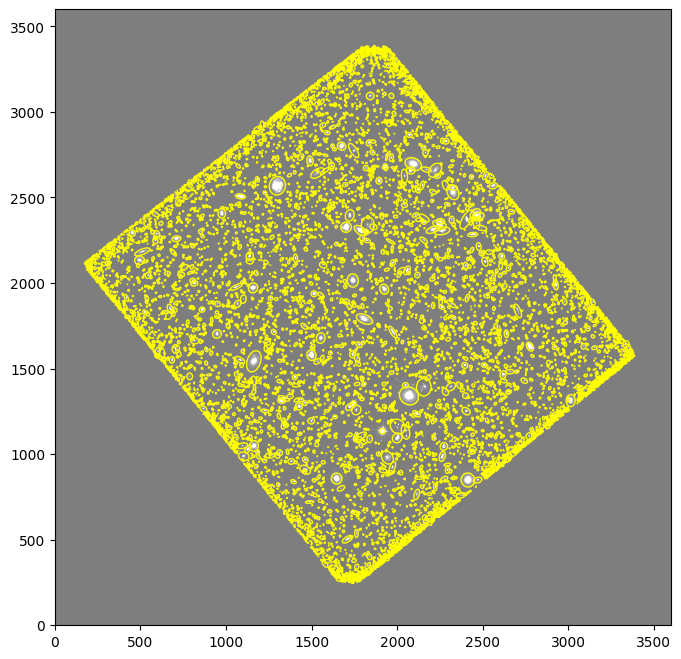

In [67]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plotting an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('yellow')
    ax.add_artist(e)
plt.savefig('DetectedObjectsHUD.png')

# *Aperture Photometry:* Simple circular photometry with a 3-pixel radius at the locations of the objects!

In [ ]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

#Now we plot to create a histogram of the fluxes
plt.hist(flux, bins='auto')
plt.title('Flux Histogram')
plt.xlabel('Flux')
plt.ylabel('Number of Sources')
plt.savefig('FluxHistogram')

for i in range(10): #
    print("object {:d}: flux = {:f} +/- {:f}".format(i,flux[i],fluxerr[i]))
    

# 8. Making a 3-Color False Image of UDF (using RGB)!